In [31]:
import os,sys
sys.path.insert(1, os.path.join(os.getcwd()  , '..'))
import shallowsim as sb
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import time
from tqdm import tqdm, trange


In [39]:
args = sb.ModelArgs()
c = sb.Config()
gpu_all_decode = sb.get_gpu_info('./device/gpu_info.csv',
                                 decoding_mode=True,print_console=True) 

| gpu_type      |   sm |   comm_sm |   fp16 |   fp8 |   fp4 |   mem |   mem_bw |   nvlink_bw |   pcie_bw |   gpu_per_node |
|:--------------|-----:|----------:|-------:|------:|------:|------:|---------:|------------:|----------:|---------------:|
| DGX-B300      |  160 |        20 |   3375 |  7500 | 15000 |   288 |     8000 |         900 |       100 |              8 |
| DGX-B200      |  160 |        20 |   2250 |  4500 |  9000 |   180 |     8000 |         900 |       100 |              8 |
| GB200-NVL72   |  160 |        20 |   2500 |  5000 | 10000 |   192 |     8000 |         900 |       100 |             72 |
| GB300-NVL72   |  160 |        20 |   3750 |  7500 | 15000 |   288 |     8000 |         900 |       100 |             72 |
| Rubin-NVL144  |  110 |        12 |   6400 | 12800 | 25600 |   144 |     6500 |         900 |       100 |            144 |
| RubinU-NVL576 |  110 |        12 |   6500 | 13000 | 26000 |   256 |     8000 |       13500 |       100 |            576 |
| H200  

In [55]:

# generate data
dfs = []
for seq_len in trange(1024,16384,32):
    c.seq_len = seq_len
    df = sb.decode_time_with_ep_list(args,gpu_all_decode,c,fp8_combine=True)
    df['index_value'] = seq_len
    df_o = df.groupby(['GPU','BatchSize','EP'],as_index=False).apply(lambda t: t[t.Total==t.Total.max()]).sort_values(['Total'],ascending=False).reset_index(drop=True)
    df_o.drop_duplicates(subset=['GPU','BatchSize','EP'], keep='first', inplace=True)
    dfs.append(df_o)
df = pd.concat(dfs)    
df.reset_index(inplace=True,drop=True)
df.to_csv('perf_vs_seq_len.csv')


100%|████████████████████████████████████████████████████████████████████████████████████████| 480/480 [05:22<00:00,  1.49it/s]


In [34]:
df = pd.read_csv('perf_vs_seq_len.csv')


In [58]:
#df1 = df[df['EP'] == 144].reset_index(drop=True)
df1 = df[df['BatchSize'] == 128].reset_index(drop=True)

In [59]:
df[df['GPU']=='Rubin-NVL144']

,GPU,TP,EP,BatchSize,DenseMLA,DenseMLP,SparseMLA,Combine,SharedExpert,RoutedExpert,...,COMM_SUM,Delta,TPOT,TPOT_O,TPS,TPS_O,Total,Total_O,Comm_Impact,index_value
4,Rubin-NVL144,1,320,512,0.125779,0.087069,0.175779,0.046601,0.010562,0.031287,...,0.093203,-0.093138,13.260987,13.260987,75.409166,75.409166,38609.492785,38609.492785,0.0,1024
5,Rubin-NVL144,1,144,512,0.125779,0.087069,0.175779,0.046601,0.010562,0.038889,...,0.093203,-0.093138,13.701892,13.701892,72.982619,72.982619,37367.101078,37367.101078,0.0,1024
8,Rubin-NVL144,1,72,512,0.125779,0.087069,0.175779,0.046601,0.010562,0.054093,...,0.093203,-0.093138,14.583702,14.583702,68.569693,68.569693,35107.682941,35107.682941,0.0,1024
12,Rubin-NVL144,4,320,256,0.062889,0.077742,0.104387,0.028301,0.009082,0.019445,...,0.056601,-0.056868,8.130882,8.130882,122.987894,122.987894,31484.900985,31484.900985,0.0,1024
15,Rubin-NVL144,1,36,512,0.125779,0.087069,0.175779,0.046601,0.011056,0.088448,...,0.093203,-0.093632,16.604902,16.604902,60.223180,60.223180,30834.268244,30834.268244,0.0,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150836,Rubin-NVL144,8,72,16,0.045681,0.068999,0.093223,0.011144,0.008249,0.035588,...,0.022288,-0.079185,8.293599,8.293599,120.574917,120.574917,1929.198678,1929.198678,0.0,16352
150853,Rubin-NVL144,8,36,16,0.045681,0.068999,0.093223,0.011144,0.008411,0.067291,...,0.022288,-0.079347,10.141737,10.141737,98.602438,98.602438,1577.639002,1577.639002,0.0,16352
150870,Rubin-NVL144,1,8,32,0.091361,0.069582,0.141361,0.012288,0.010192,0.263983,...,0.024575,-0.126979,24.583951,24.583951,40.676944,40.676944,1301.662220,1301.662220,0.0,16352
150884,Rubin-NVL144,8,16,16,0.045681,0.068999,0.093223,0.011144,0.008897,0.131991,...,0.022288,-0.079833,13.922532,13.922532,71.826016,71.826016,1149.216261,1149.216261,0.0,16352


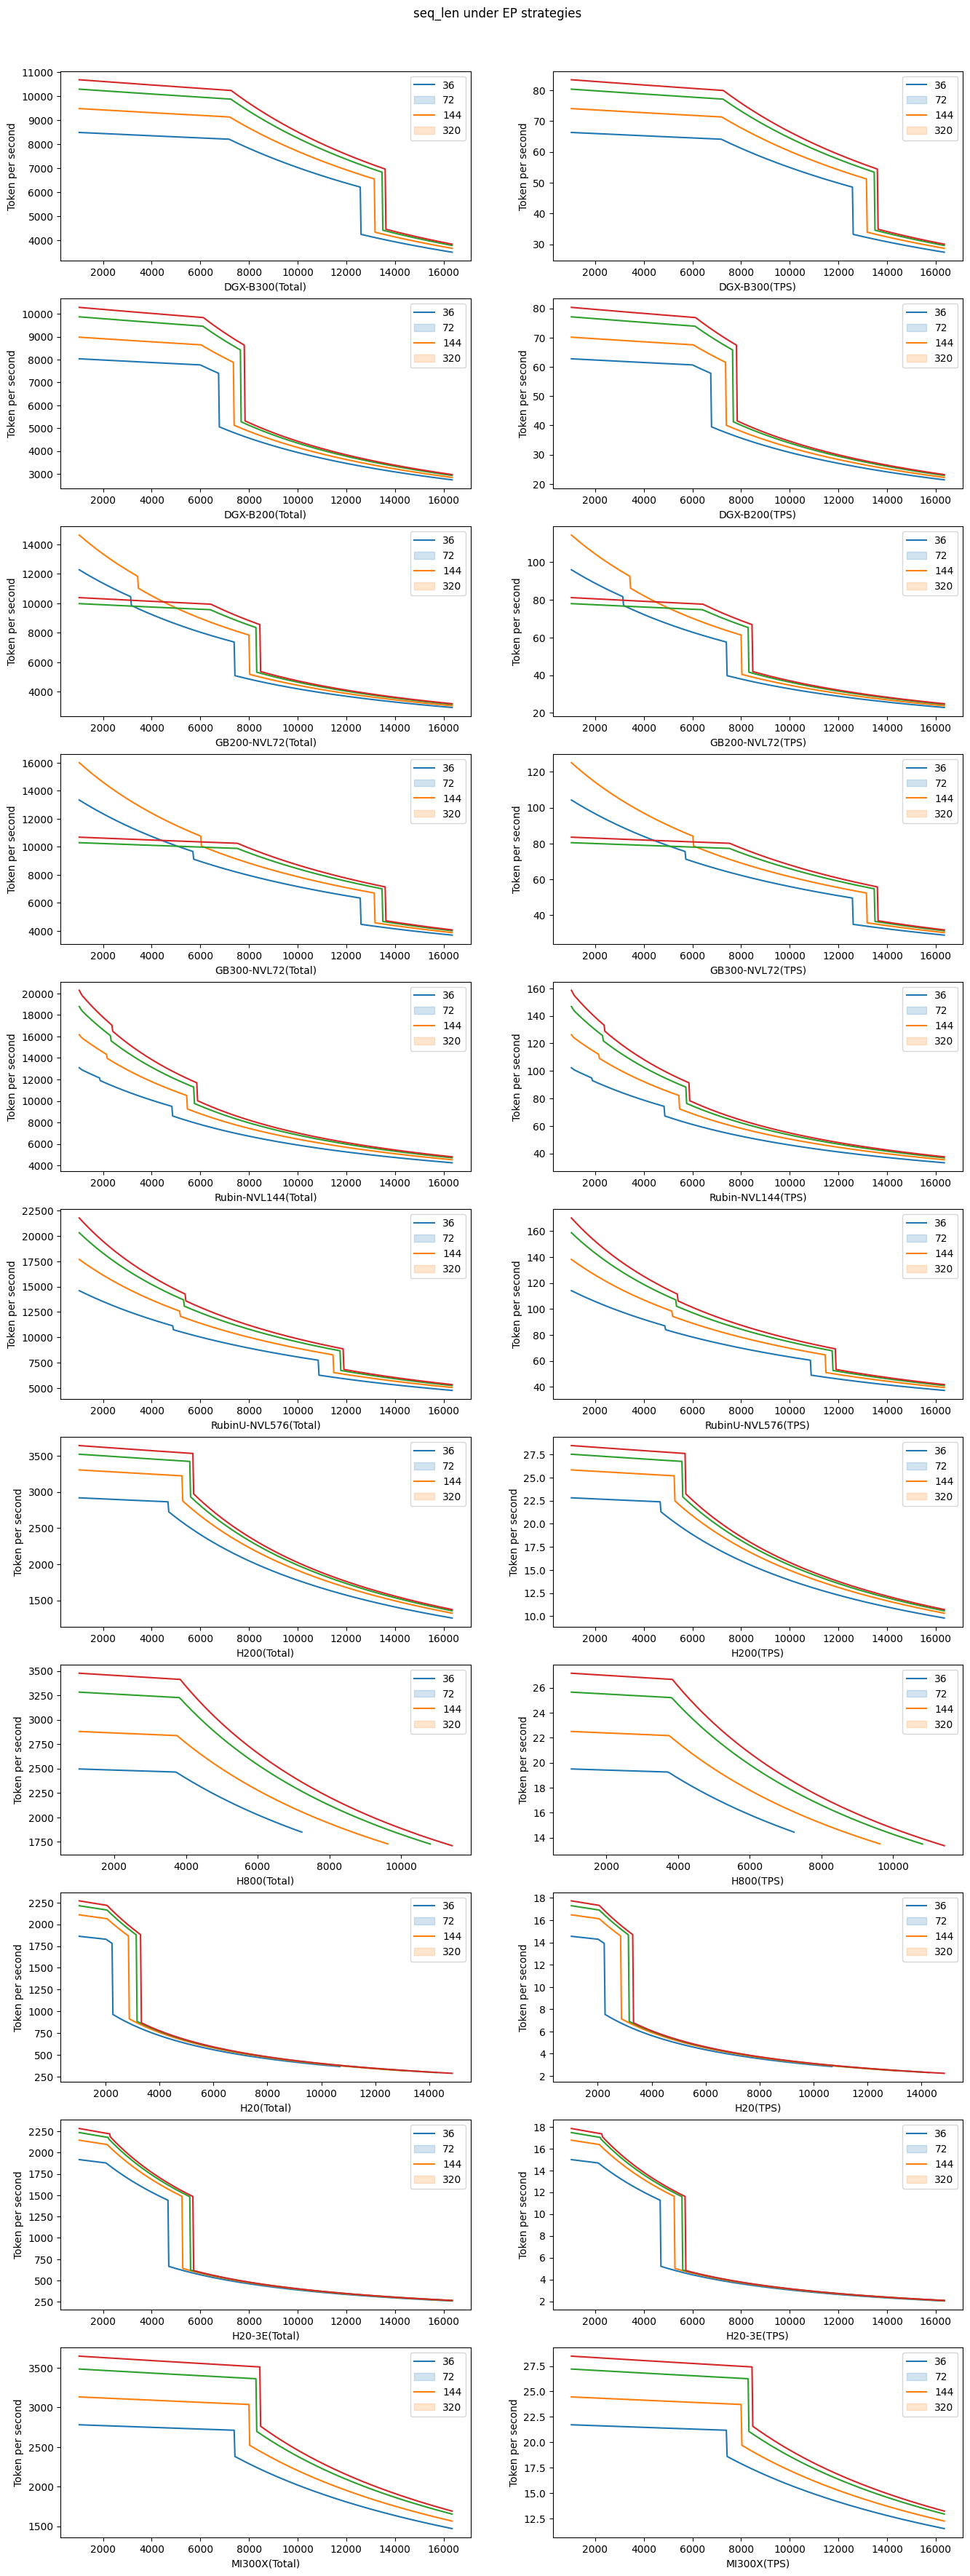

In [60]:
#gpu_all_decode = sb.get_gpu_info('./device/gpu_info.csv',
#                                 device_list=['GB300-NVL72','H800','H20'],
#                                 decoding_mode=True) 

sb.draw(df1, gpu_all_decode, 
        comp_name='EP',comp_val_list=[36,72,144,320],
        val_list=['Total','TPS'],val_unit_name='Token per second',
        title='seq_len under EP strategies')

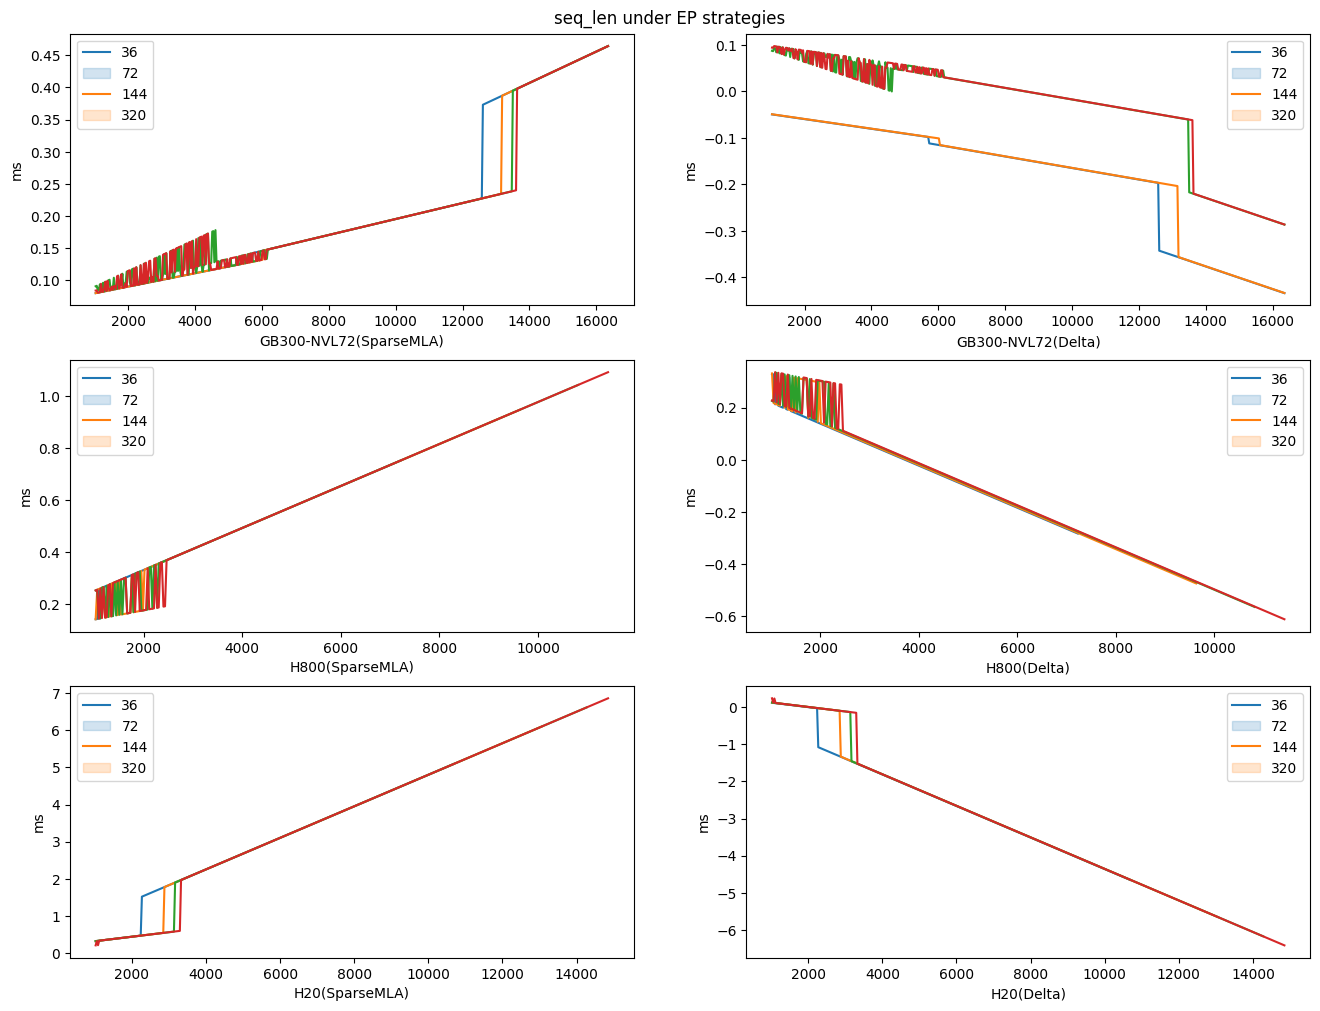

In [28]:
sb.draw(df1, gpu_all_decode, 
        comp_name='EP',comp_val_list=[36,72,144,320],
        val_list=['SparseMLA','Delta'],val_unit_name='ms',
        title='seq_len under EP strategies')